In [1]:
!pip install kmodes
!pip install shap
!pip install kneed
!pip install umap

     |████████████████████████████████| 356 kB 5.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491639 sha256=c46d7551b681ea5ae41788a215d56283eb37076645b47669a2904741dd6533e7
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3564 sha256=a63289aa8591db5bfdfaacdc2ad094dbfad811d0a6a73a2b9eed895b35cbb8a2
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [2]:
import shap
import umap
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import xgboost as xgb

from collections import Counter
from math import floor, sqrt, log
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier
from tqdm import tqdm
from kneed import KneeLocator

from scipy import special 
from scipy.stats import pearsonr, chi2_contingency, entropy

from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, f_regression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

from google.colab import files

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [3]:
files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv
Saving DT_Smote_Interpolate.sav to DT_Smote_Interpolate.sav
Saving Ensemble_Smote_Interpolate.sav to Ensemble_Smote_Interpolate.sav
Saving LR_Smote_Interpolate.sav to LR_Smote_Interpolate.sav
Saving RF_Smote_Interpolate.sav to RF_Smote_Interpolate.sav
Saving SVM_Smote_Interpolate.sav to SVM_Smote_Interpolate.sav
Saving XGB_Smote_Interpolate.sav to XGB_Smote_Interpolate.sav


In [4]:
data_df = pd.read_csv('bank-additional-full.csv', sep = ';')

# Preprocessing

In [5]:
## Replace admin. with admin
data_df.loc[data_df['job'] == 'admin.', 'job'] = 'admin'

In [6]:
## Drop duration since it is not a known variable when deciding to contact someone
data_df.drop(['duration'], axis = 1, inplace = True)

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

Feature engineer the columns
- age
- pdays
- previous

In [8]:
## Bin Age
bins = [16, 25, 35, 45, 55, 65, 100]
labels = ['youth', 'young_adult', 'adult', 'old_adult', 'senior', 'old_senior']
data_df['age'] = pd.cut(data_df['age'], bins = bins, labels = labels)
data_df['age'] = data_df['age'].astype('object')

In [9]:
## Bin Pdays
bins_pdays = [-1, 1, 7, 14, 21, 31, 999]
labels_pdays = ['next day', 'week', 'week2', 'week3', 'week4', 'ncntc_ncustmer']
data_df['pdays'] = pd.cut(data_df['pdays'], bins = bins_pdays, labels = labels_pdays)
data_df['pdays'] = data_df['pdays'].astype('object')

Plotting correlation matrix and identifying variables with multicollinearity


housing,loan 0.7078524775105789
previous,poutcome 0.8881354042310704
emp.var.rate,cons.price.idx 0.7753341708349993
emp.var.rate,euribor3m 0.9722446711516126
emp.var.rate,nr.employed 0.9069701012560618
euribor3m,nr.employed 0.9451544313982774


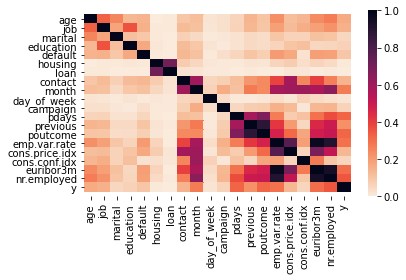

In [10]:
column_names = data_df.columns.tolist()
corr_dict = {'age': 'categorical',
             'job': 'categorical',
             'marital': 'categorical',
             'education': 'categorical',
             'default': 'categorical',
             'housing': 'categorical',
             'loan': 'categorical',
             'contact': 'categorical',
             'month': 'categorical',
             'day_of_week': 'categorical',
             'campaign': 'continuous',
             'pdays': 'categorical',
             'previous': 'continuous',
             'poutcome': 'categorical',
             'emp.var.rate': 'continuous',
             'cons.price.idx': 'continuous',
             'cons.conf.idx': 'continuous',
             'euribor3m': 'continuous',
             'nr.employed': 'continuous',
             'y': 'categorical'}

corr_matrix = np.zeros((len(column_names), len(column_names)))
corr_matrix = pd.DataFrame(corr_matrix, columns = column_names, index = column_names)

def cramers_corrected_stat(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def correlation_coeff(x, y):
    abs_corr = abs(x.corr(y, method = 'pearson'))
    return abs_corr

for key in corr_dict:
    for key2 in corr_dict:
        if corr_dict[key] == 'continuous' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_coeff(data_df[key], data_df[key2])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_ratio(data_df[key], data_df[key2])
        elif corr_dict[key] == 'continuous' and corr_dict[key2] == 'categorical':
            curr_corr = correlation_ratio(data_df[key2], data_df[key])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'categorical':
            curr_corr = cramers_corrected_stat(data_df[key], data_df[key2])
        corr_matrix[key][key2] = curr_corr

        if curr_corr >= 0.7 and column_names.index(key) < column_names.index(key2):
            print(key + "," + key2 + " " + str(curr_corr))

ax = sns.heatmap(corr_matrix,
                 xticklabels = column_names,
                 yticklabels = column_names,
                 vmin = 0,
                 vmax = 1,
                 cmap = sns.cm.rocket_r)

top, bottom = ax.get_ylim()
ax.set_ylim(top + 0.5, bottom - 0.5)
plt.tight_layout()
plt.show()

Drop variables with multicollinearity issues and variables with little contribution to the target variable as explored from the EDA.



In [11]:
## Drop following columns with multicollinearity issues
data_df.drop(['previous', 'emp.var.rate', 'nr.employed', 'default', 'marital', 'day_of_week', 'housing', 'loan', 'campaign'], axis = 1, inplace = True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  object 
 1   job             41188 non-null  object 
 2   education       41188 non-null  object 
 3   contact         41188 non-null  object 
 4   month           41188 non-null  object 
 5   pdays           41188 non-null  object 
 6   poutcome        41188 non-null  object 
 7   cons.price.idx  41188 non-null  float64
 8   cons.conf.idx   41188 non-null  float64
 9   euribor3m       41188 non-null  float64
 10  y               41188 non-null  object 
dtypes: float64(3), object(8)
memory usage: 3.5+ MB


So right now, we want to predict the unknown values in the dataframe. To do so, we first create a copy of the original dataframe. Then we shall predict those columns with unknown values. After that, we shall replace the original dataframe with those new columns. 

# Encoding of Categorical Variables

In [12]:
## One Hot Encoding for categorical variables
def dummy(ohe_cols, df):
    d1 = pd.get_dummies(df[ohe_cols], drop_first = True)
    d2 = pd.concat([df, d1], axis = 1)
    d2.drop(ohe_cols, axis = 1, inplace=  True) 
    return d2

In [13]:
## Function for Label Encoding
def le_encoder(df, le):
    df = df.replace(le)
    return df

In [14]:
## Multi Layered Categorical variables are label encoded for us to interpolate unknown values for the time being
le_unknown = {
    'job': {'unknown': 0, 'unemployed': 1, 'student':2, 'blue-collar': 3, 'housemaid': 4, 'admin': 5, 'services': 6, 
           'technician': 7, 'self-employed': 8, 'entrepreneur': 9, 'management': 10, 'retired': 11}, 
    'age': {'young_adult': 1, 'old_senior': 5, 'adult': 2, 'senior': 4, 'youth': 0, 'old_adult': 3},  
    'education': {'basic.4y': 2, 'high.school': 5, 'basic.6y': 3 , 'basic.9y': 4, 'professional.course': 6, 'unknown': 0,
                  'university.degree': 7, 'illiterate': 1}, 
    'contact': {'cellular': 1, 'telephone': 0}, 
    'y': {'yes': 1, 'no': 0}, 
    'housing': {'yes': 1, 'no': 0},
    'loan': {'yes': 1, 'no': 0}, 
    'default': {'yes': 1, 'no': 0}
}

In [15]:
ohe_cols_for_unknown_prediction = ['month', 'pdays', 'poutcome']

In [16]:
temp_df = data_df.copy()

In [17]:
## Identify number of unknown values for the following features
print(f"I should expect job to have {temp_df[temp_df['job'] == 'unknown'].shape[0]} unknown rows")
print(f"I should expect education to have {temp_df[temp_df['education'] == 'unknown'].shape[0]} unknown rows")

I should expect job to have 330 unknown rows
I should expect education to have 1731 unknown rows


In [18]:
temp_encoded_df = le_encoder(temp_df, le_unknown) ## Label Encode first
temp_encoded_df = dummy(ohe_cols_for_unknown_prediction, temp_encoded_df) ## Hot Encode

# Interpolating of unknown variables

In [19]:
## Function to predict uknown value based on the value of other columns
def unknown_predictor(df, cols): # takes og df -> returns og df with unknown values predicted
    df_cols = df.columns

    for col in cols:
        if col in df_cols:
            rf = RandomForestClassifier()
            test_col = df[df[col] == 0] # 0 represents the unknown value, according to our label encoding. 
            train_col = df[df[col] != 0]
            test_col.drop(['y'], axis=1, inplace=True)
            train_col.drop(['y'], axis=1, inplace=True)
            X_train = train_col.loc[:, train_col.columns != col]
            y_train = train_col.loc[:, col]
            X_test = test_col.loc[:, test_col.columns != col]
            y_test = test_col.loc[:, col]


            rf.fit(X_train, y_train)
            col_predictions = rf.predict(X_test)
            df.loc[df[col] == 0, col] = col_predictions
    return df

In [20]:
unknown_cols = ['education', 'job']
temp_encoded_interp_df = unknown_predictor(temp_encoded_df.copy(), unknown_cols)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Replace Label Encoding of Job Variable with Hot Encoding

In [21]:
## Function to reverse the order of key, value in dictionary
def reverse_dict(label_dict):
    rev_dict = {value : key for (key, value) in label_dict.items()}
    return rev_dict

In [22]:
job_dict = {'job': {'unemployed': 1, 'student':2, 'blue-collar': 3, 'housemaid': 4, 'admin': 5, 'services': 6, 
           'technician': 7, 'self-employed': 8, 'entrepreneur': 9, 'management': 10, 'retired': 11}}
job_dict_reverse = {}
for key in job_dict:
    job_dict_reverse[key] = reverse_dict(job_dict[key])

In [23]:
## Reverse the Label Encoding of Job
temp_encoded_interp_df = temp_encoded_interp_df.replace(job_dict_reverse)

In [24]:
## Update dataframe and hot encode Job feature
data_df = dummy(['job'], temp_encoded_interp_df)

# Train and Test datasets

We are going to do stratified sampling twice. To ensure consistency in the points chosen, we have fixed the random state of the sampling.
1. Stratified Sampling to obtain our test dataset. (This is done here so that we would only run inference on actual points, rather than SMOTE generated points)
2. SMOTE to address the class imbalance in our dataset.
3. Stratified sampling on the updated dataset to obtain our training dataset.

## Stratified Sampling to produce test dataset

In [25]:
stratified = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_set, test_set in stratified.split(data_df, data_df['y']):
    stratified_train = data_df.loc[train_set]
    stratified_test = data_df.loc[test_set]
    
X_test = stratified_test.loc[:, stratified_test.columns != 'y'] # we test on this
y_test = stratified_test.loc[:, 'y'] # we test on this
X_train = stratified_train.loc[:, stratified_train.columns != 'y'] 
y_train = stratified_train.loc[:, 'y']


## SMOTE to generate synthetic data

In [26]:
X = data_df.loc[:, data_df.columns != 'y'] # this dataset combines training and validation data
y =  data_df.loc[:, 'y']
oversample = SMOTE(random_state = 42)
X_oversampled, y_oversampled = oversample.fit_resample(X, y) 

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


## Stratified Sampling to produce training dataset

In [27]:
# Now that we have oversampled, we split the data into train and test sets. 
data_os_df = pd.DataFrame(X_oversampled)
data_os_df['y'] = y_oversampled

In [28]:
stratified = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_set, test_set in stratified.split(data_os_df, data_os_df['y']):
    stratified_train_os = data_os_df.loc[train_set]
    stratified_test_os = data_os_df.loc[test_set]

X_train_os = stratified_train_os.loc[:, stratified_train_os.columns != 'y'] # this dataset combines training and validation data
y_train_os = stratified_train_os.loc[:, 'y'] 

In [29]:
X_test = X_test.rename(columns={x:y for x, y in zip(X_test.columns, range(0, len(X_test.columns)))})

# Dictionary to store:
1. Model Scores
2. training probability and test probability to create ensemble

In [30]:
model_scores = {}
train_prob = {}
test_prob = {}

# Functions for Models

In [31]:
## Function to produce confusion matric
def cm_matrix(y_pred, y_test):
    cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
    cm.columns = ['True Y = 0', 'True Y = 1']
    cm.index = ['Predicted Y = 0','Predicted Y = 1']
    return cm

In [32]:
## Function that consolidates performance metrics of model
def results(best_model, y_test, X_test):
    scores = {}
    y_pred = best_model.predict(X_test)
    pred_proba_val = best_model.predict_proba(X_test)[:, 1]
    scores['precision'] = precision_score(y_test, y_pred)
    scores['recall'] = recall_score(y_test, y_pred)
    scores['accuracy'] = accuracy_score(y_test, y_pred)
    scores['auc'] = roc_auc_score(y_test, pred_proba_val)
    scores['f1_score'] = f1_score(y_test, y_pred)
    cm = cm_matrix(y_pred, y_test)
    specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
    scores['specificity'] = specificity
    fpr , tpr , threshold = roc_curve(y_test, pred_proba_val)
    print(scores)
    return y_pred, fpr, tpr, scores

In [33]:
## Function to generate AUC ROC Curve
def roc_auc_curve(y_test, fpr, tpr, label):
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label = 1)
    plt.plot(fpr , tpr , linestyle = '--', color = 'orange', label = label)
    plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()

In [34]:
## Function to display significance of variables in building of model
def feature_importance(train, importance, df, ensemble):
    X = list(train.columns)
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns = ['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by = 'sort', ascending = False).drop('sort', axis = 1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    '''
    if ensemble == False:
      df = df.drop(['y'], axis = 1)
      sns.barplot(x = np.array(sorted_feature_imp_df.coefficient_values[0:10]), y = df.columns[np.array(sorted_feature_imp_df.index.values)][0:10])
    else:
      sns.barplot(x = np.array(sorted_feature_imp_df.coefficient_values), y = df.columns)
    plt.title('Feature Importance', fontsize=20)
    plt.xlabel('Log-Odds', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    '''
    if ensemble == False:
      df = df.drop(['y'], axis = 1)
      sns.barplot(x = df.columns[np.array(sorted_feature_imp_df.index.values)], y = np.array(sorted_feature_imp_df.coefficient_values))
    else:
      sns.barplot(x = np.array(sorted_feature_imp_df.index.values), y = np.array(sorted_feature_imp_df.coefficient_values)) 
    plt.title('Model Importance', fontsize=20)
    plt.xlabel('Model Names', fontsize = 20)
    plt.ylabel('Significance', fontsize = 20)
    plt.xticks(fontsize=16, rotation = 90)
    plt.yticks(fontsize=20)
    
    plt.show()

In [35]:
def load_model(path):
  import pickle
  loaded_model = pickle.load(open(path, 'rb'))
  return loaded_model

In [36]:
def save_model(clf, path):
  import pickle
  pickle.dump(clf, open(path, 'wb'))
  return None

# Pre Trained Weights

## Decision Tree Classifier

In [37]:
decision_tree_clf = load_model('DT_Smote_Interpolate.sav')

In [38]:
y_pred, fpr, tpr, decisiontree_clf_scores = results(decision_tree_clf, y_test, X_test)

{'precision': 0.4748201438848921, 'recall': 0.5689655172413793, 'accuracy': 0.8805535324107793, 'auc': 0.7859742794471437, 'f1_score': 0.5176470588235295, 'specificity': 0.920109439124487}


In [39]:
train_prob['Decision Trees'] = decision_tree_clf.predict_proba(X_train_os)[:, 1]
test_prob['Decision Trees'] = decision_tree_clf.predict_proba(X_test)[:, 1]

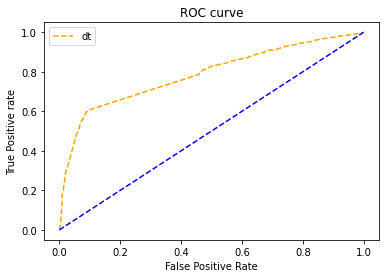

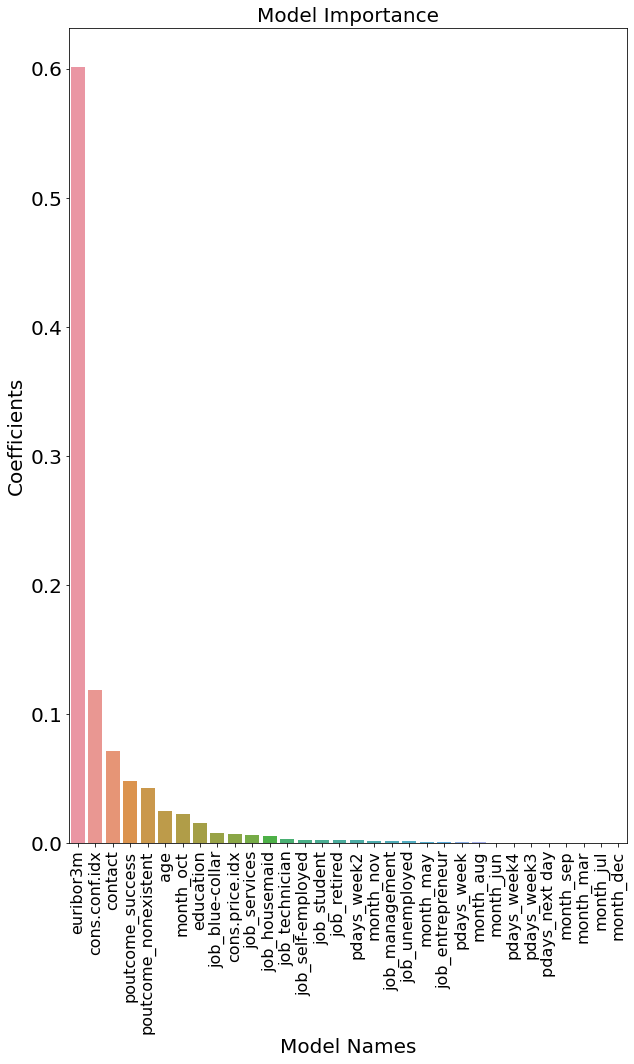

In [40]:
model_scores[decision_tree_clf] = decisiontree_clf_scores
roc_auc_curve(y_test, fpr, tpr, 'dt')
importances = decision_tree_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_os.columns)
feature_importance(X_train_os, forest_importances, data_df, False)

## Random Forest Classifier

In [41]:
random_forest_clf = load_model('RF_Smote_Interpolate.sav')

In [42]:
y_pred, fpr, tpr, randomforest_clf_scores = results(random_forest_clf, y_test, X_test)

{'precision': 0.4595918367346939, 'recall': 0.6066810344827587, 'accuracy': 0.8753338188880796, 'auc': 0.8161539901646304, 'f1_score': 0.5229911751045053, 'specificity': 0.9094391244870041}


In [43]:
train_prob['Random Forest'] = random_forest_clf.predict_proba(X_train_os)[:, 1]
test_prob['Random Forest'] = random_forest_clf.predict_proba(X_test)[:, 1]

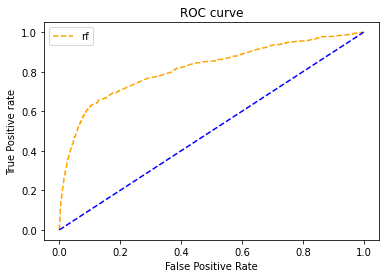

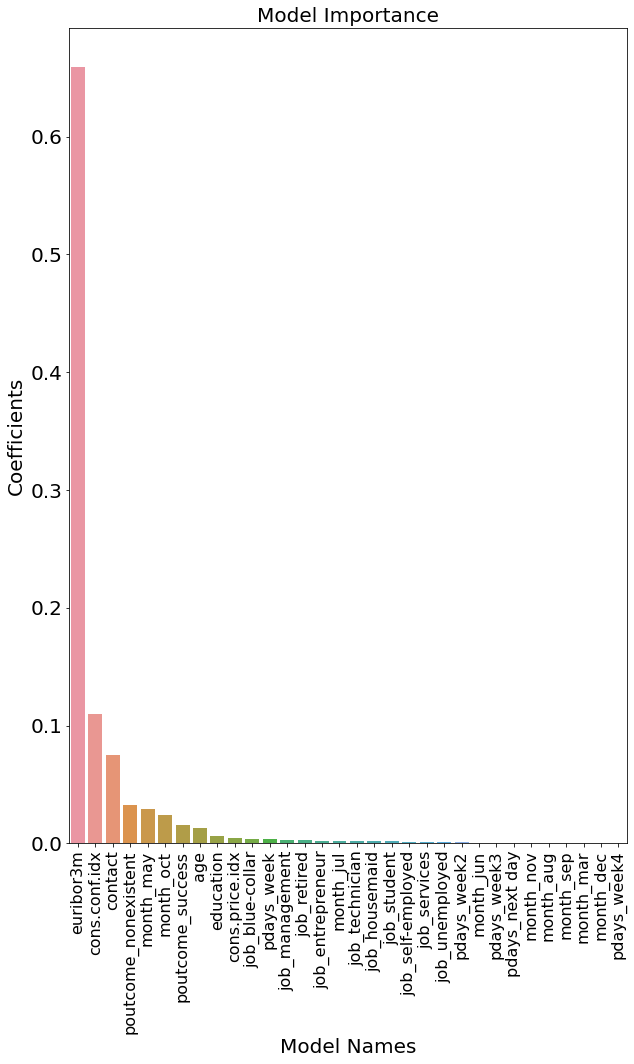

In [44]:
model_scores[random_forest_clf] = randomforest_clf_scores
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = random_forest_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_os.columns)
feature_importance(X_train_os, forest_importances, data_df, False)

## XGBoost Classifier

In [45]:
xgb_clf = load_model('XGB_Smote_Interpolate.sav')

In [46]:
y_pred, fpr, tpr, xgb_clf_scores = results(xgb_clf, y_test, X_test)

{'precision': 0.5208333333333334, 'recall': 0.5118534482758621, 'accuracy': 0.891964068948774, 'auc': 0.825509163168074, 'f1_score': 0.5163043478260869, 'specificity': 0.940218878248974}


In [47]:
train_prob['XGB'] = xgb_clf.predict_proba(X_train_os)[:, 1]
test_prob['XGB'] = xgb_clf.predict_proba(X_test)[:, 1]

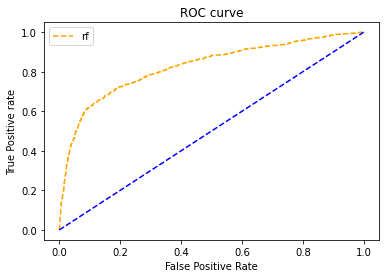

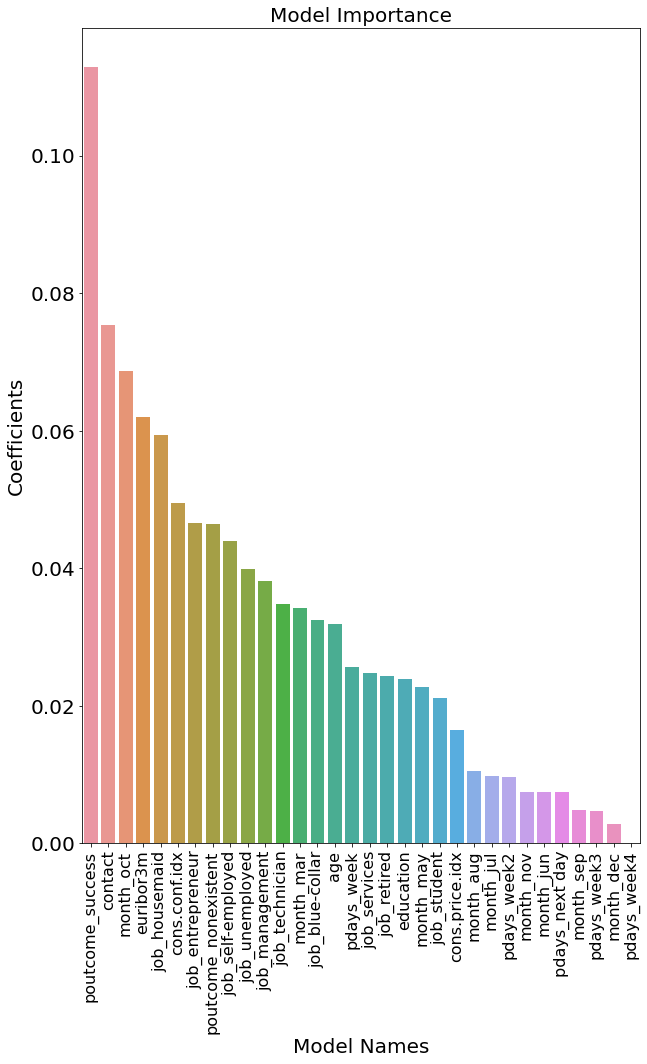

In [48]:
model_scores[xgb_clf] = xgb_clf_scores
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = xgb_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_os.columns)
feature_importance(X_train_os, forest_importances, data_df, False)

## Logistic Regression Classifier

In [49]:
logreg_clf = load_model('LR_Smote_Interpolate.sav')

In [50]:
y_pred, fpr, tpr, logreg_clf_scores = results(logreg_clf, y_test, X_test)

{'precision': 0.34151785714285715, 'recall': 0.6594827586206896, 'accuracy': 0.8184025248846808, 'auc': 0.7980862894476155, 'f1_score': 0.45, 'specificity': 0.8385772913816689}


In [51]:
train_prob['Log'] = logreg_clf.predict_proba(X_train_os)[:, 1]
test_prob['Log'] = logreg_clf.predict_proba(X_test)[:, 1]

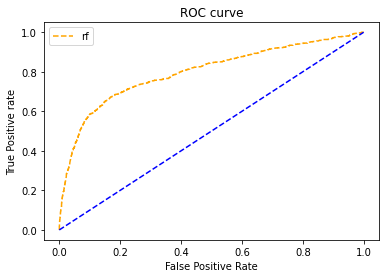

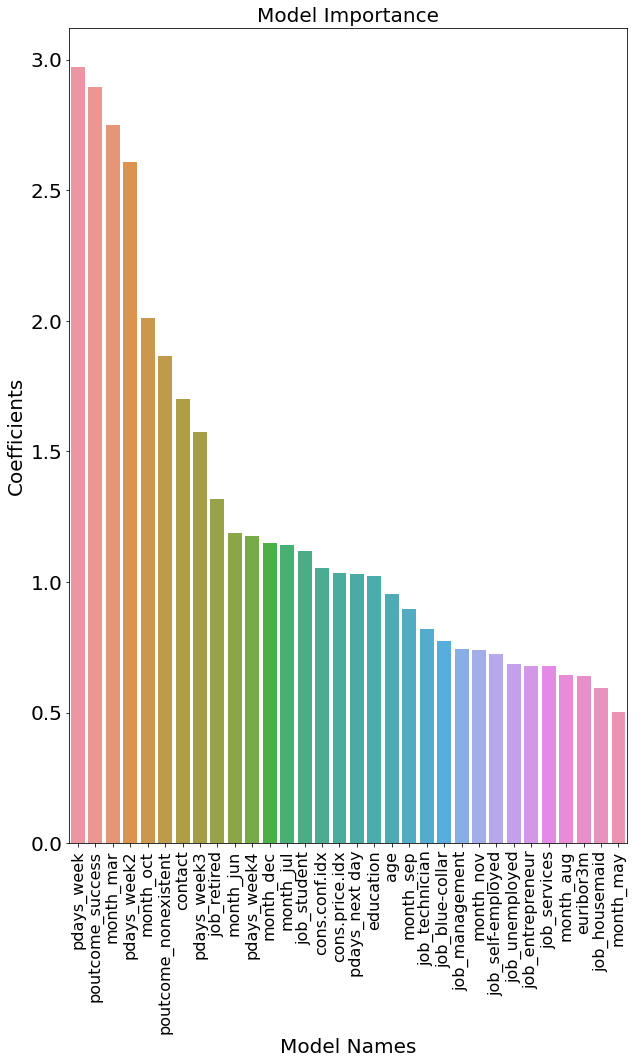

In [52]:
model_scores[logreg_clf] = logreg_clf_scores
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = logreg_clf.best_estimator_.named_steps['classifier'].coef_[0]
logodds = np.exp(pd.Series(importances, index = X_train_os.columns))
feature_importance(X_train_os, logodds, data_df, False)

In [53]:
## Identify Insignificant features
f_val, p_val = f_regression(X_train_os, y_train_os)
print(data_df.columns[np.where(p_val > 0.05)])

Index(['job_technician'], dtype='object')


Only one insignficant feature is found. As it is part of a hot-encoded variable with 12 levels, it is kept.

## Ensemble (Decision Tree, Random Forest, XGBoost and Logistic Regression)

In [54]:
ensemble_clf = load_model('Ensemble_Smote_Interpolate.sav')

In [55]:
X_train_df = pd.DataFrame(train_prob)
X_test_df = pd.DataFrame(test_prob)

In [56]:
y_pred, fpr, tpr, ensemble_clf_scores = results(ensemble_clf, y_test, X_test_df)

{'precision': 0.5224719101123596, 'recall': 0.5010775862068966, 'accuracy': 0.8922068463219228, 'auc': 0.8441044536298883, 'f1_score': 0.5115511551155116, 'specificity': 0.9418604651162791}


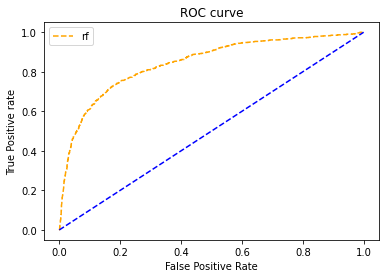

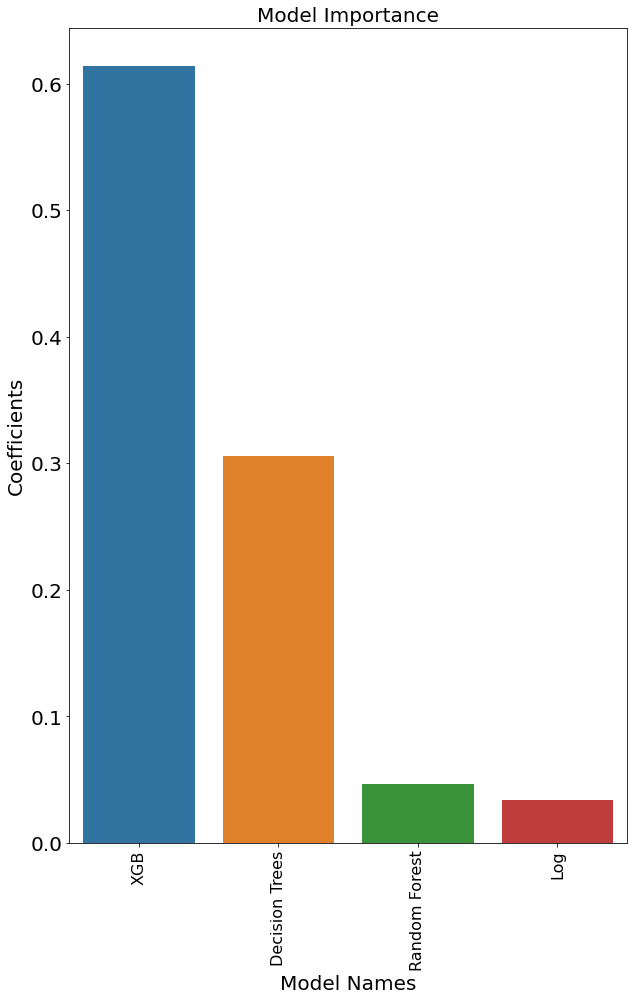

In [57]:
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = ensemble_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_df.columns)
feature_importance(X_train_df, forest_importances, X_train_df, True)

## SVM (RBF Kernel) Classifier

In [58]:
svm_clf = load_model('SVM_Smote_Interpolate.sav')

In [59]:
y_pred, fpr, tpr, svm_clf_scores = results(svm_clf, y_test, X_test)

{'precision': 0.2543006731488407, 'recall': 0.7327586206896551, 'accuracy': 0.72784656470017, 'auc': 0.7763219963205812, 'f1_score': 0.3775680177679067, 'specificity': 0.7272229822161422}


In [60]:
# test_prob['SVM'] = svm_clf.predict_proba(X_test)[:, 1]

In [61]:
model_scores[svm_clf] = svm_clf_scores

# Train models

### GridSearchCV using 5 fold cross validation, under rocauc.

In [67]:
## Function for Hyper Parameter Tuning
def hyperparameter_tuning(parameters, scores, model, X_train, y_train):
    best_params = {}
    for score in scores:
        best_model = GridSearchCV(
            model, parameters, scoring=score, cv = 5, n_jobs = -1
        )
        best_model.fit(X_train, y_train)
        best_params[score] = best_model.best_params_
    return best_params

In [68]:
## Search Grid
model_dt = DecisionTreeClassifier(random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_xgb = xgb.XGBClassifier(objective = 'binary:logistic', nthread = 4, seed = 42)

tuned_parameters_dt = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 5)
} 
tuned_parameters_rf = { 
    'n_estimators': list(range(10, 101, 10)),
    'max_features': list(range(6,32,5)),
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}
tuned_parameters_xgb = {
    'max_depth': range(2, 5, 1),
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.1, 0.01, 0.05],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
scores = ['precision_macro']

tuned_parameters_lr = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
]

### Decision Tree Classifier

In [ ]:
dt_params = hyperparameter_tuning(tuned_parameters_dt, scores, model_dt, X_train_os, y_train_os)

In [ ]:
criterion = dt_params['precision_macro']['criterion']
max_depth = dt_params['precision_macro']['max_depth']
min_samples_leaf = dt_params['precision_macro']['min_samples_leaf']
min_samples_split =  dt_params['precision_macro']['min_samples_split']
decision_tree_clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
decision_tree_clf.fit(X_train_os, y_train_os)

In [ ]:
train_prob['Decision Trees'] = decision_tree_clf.predict_proba(X_train_os)[:, 1]
test_prob['Decision Trees'] = decision_tree_clf.predict_proba(X_test)[:, 1]

In [ ]:
y_pred, fpr, tpr, decisiontree_clf_scores = results(decision_tree_clf, y_test, X_test)

{'precision': 0.4748201438848921, 'recall': 0.5689655172413793, 'accuracy': 0.8805535324107793, 'auc': 0.7860465853342137, 'f1_score': 0.5176470588235295, 'specificity': 0.920109439124487}


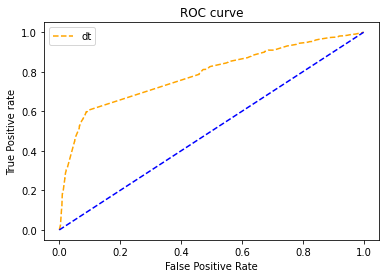

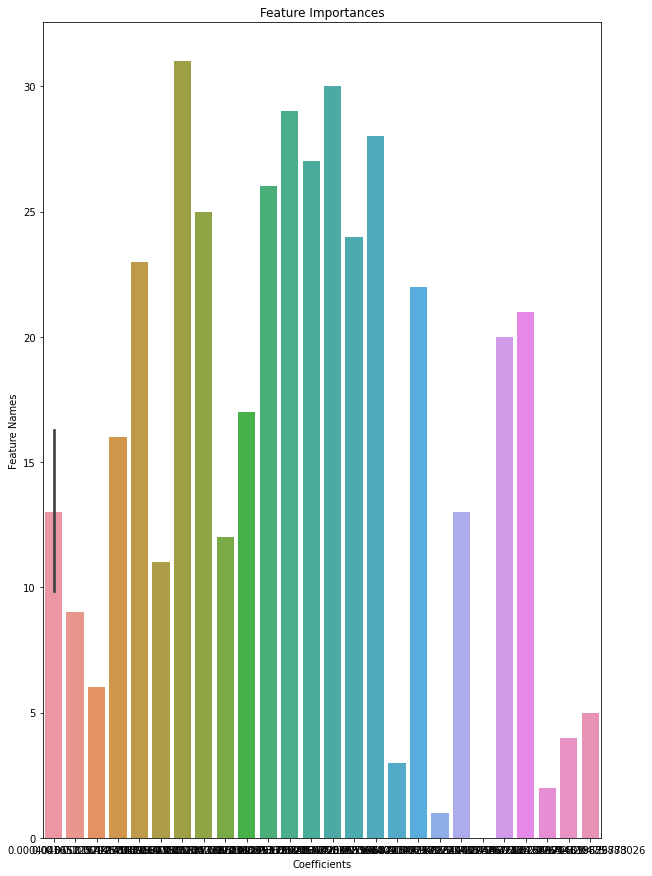

In [ ]:
model_scores[decision_tree_clf] = decisiontree_clf_scores
roc_auc_curve(y_test, fpr, tpr, "dt")
importances = decision_tree_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_os.columns)
feature_importance(X_train_os, forest_importances, data_df, False)

### Random Forest Classifier

In [ ]:
rf_params = hyperparameter_tuning(tuned_parameters_rf, scores, model_rf, X_train_os, y_train_os)

In [ ]:
criterion = rf_params['precision_macro']['criterion']
max_depth = rf_params['precision_macro']['max_depth']
n_estimators = rf_params['precision_macro']['n_estimators']
max_features =  rf_params['precision_macro']['max_features']
random_forest_clf = RandomForestClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features, n_estimators = n_estimators)
random_forest_clf.fit(X_train_os, y_train_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=31,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
train_prob['Random Forest'] = random_forest_clf.predict_proba(X_train_os)[:, 1]
test_prob['Random Forest'] = random_forest_clf.predict_proba(X_test)[:, 1]

In [ ]:
y_pred, fpr, tpr, randomforest_clf_scores = results(random_forest_clf, y_test, X_test)

{'precision': 0.4595918367346939, 'recall': 0.6066810344827587, 'accuracy': 0.8753338188880796, 'auc': 0.8161629086277655, 'f1_score': 0.5229911751045053, 'specificity': 0.9094391244870041}


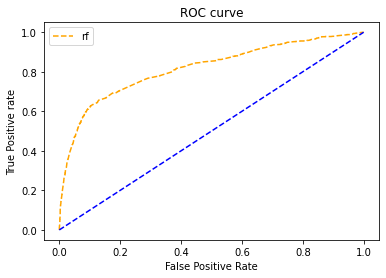

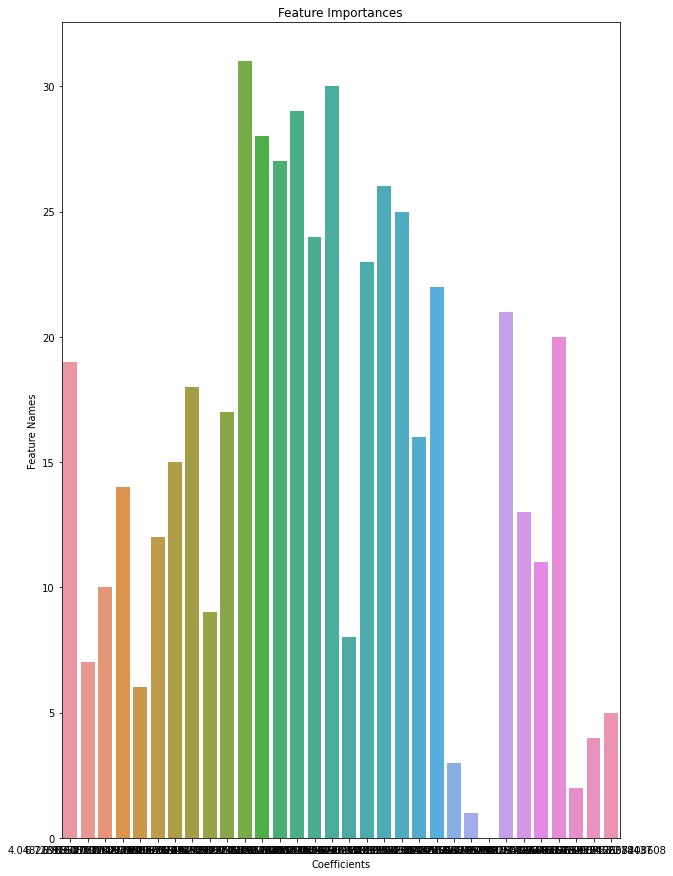

In [ ]:
model_scores[random_forest_clf] = randomforest_clf_scores
roc_auc_curve(y_test, fpr, tpr, "rf")
importances = random_forest_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_os.columns)
feature_importance(X_train_os, forest_importances, data_df, False)

### XGBoost Classifier

In [ ]:
xgb_params = hyperparameter_tuning(tuned_parameters_xgb, scores, model_xgb, X_train_os, y_train_os)

In [ ]:
n_estimators = xgb_params['precision_macro']['n_estimators']
max_depth = xgb_params['precision_macro']['max_depth']
learning_rate = xgb_params['precision_macro']['learning_rate']
colsample_bytree =  xgb_params['precision_macro']['colsample_bytree']
xgb_clf = xgb.XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, colsample_bytree = colsample_bytree)
xgb_clf.fit(X_train_os, y_train_os)

In [ ]:
y_pred, fpr, tpr, xgb_clf_scores = results(xgb_clf, y_test, X_test)

{'precision': 0.521978021978022, 'recall': 0.5118534482758621, 'accuracy': 0.8922068463219228, 'auc': 0.8259977622765226, 'f1_score': 0.5168661588683352, 'specificity': 0.9404924760601915}


In [ ]:
train_prob['XGB'] = xgb_clf.predict_proba(X_train_os)[:, 1]
test_prob['XGB'] = xgb_clf.predict_proba(X_test)[:, 1]

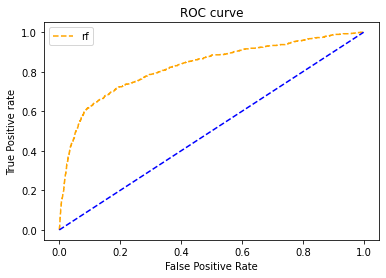

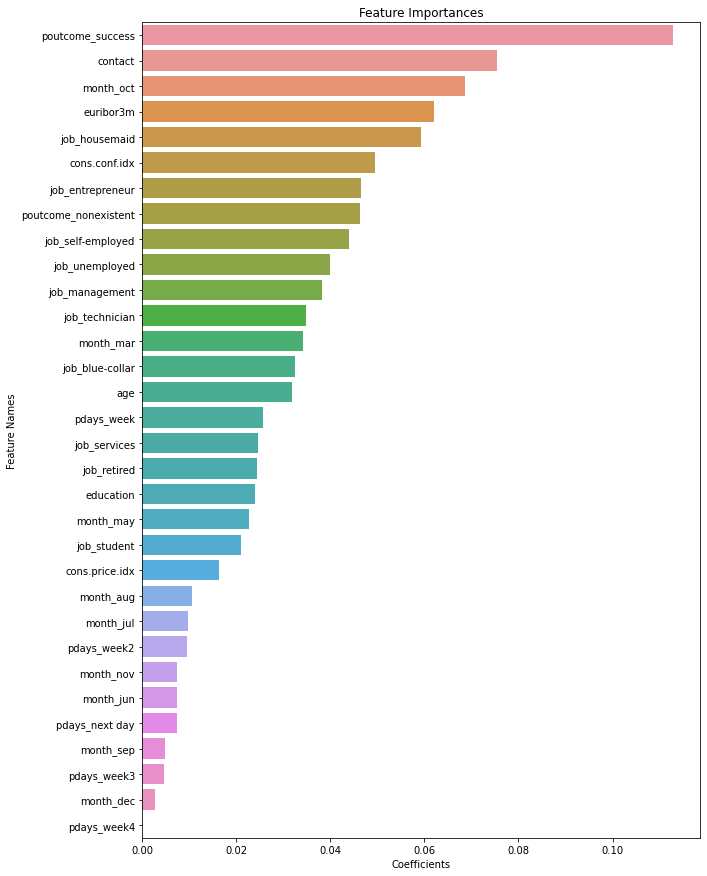

In [ ]:
model_scores[xgb_clf] = xgb_clf_scores
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = xgb_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train.columns)
feature_importance(X_train, forest_importances, data_df, False)

### Logistic Regression Classifier

In [69]:
clf = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())]), param_grid = tuned_parameters_lr, cv = 5, verbose=True, n_jobs=-1)
logreg_clf = clf.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished


In [70]:
y_pred, fpr, tpr, logreg_clf_scores = results(logreg_clf, y_test, X_test)

{'precision': 0.3479749001711352, 'recall': 0.6573275862068966, 'accuracy': 0.8226511289147851, 'auc': 0.7987517099863202, 'f1_score': 0.45505408429690414, 'specificity': 0.8436388508891929}


In [ ]:
train_prob['Log'] = logreg_clf.predict_proba(X_train_os)[:, 1]
test_prob['Log'] = logreg_clf.predict_proba(X_test)[:, 1]

In [ ]:
model_scores[logreg_clf] = logreg_clf_scores
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = logreg_clf.best_estimator_.named_steps['classifier'].coef_[0]
logodds = np.exp(pd.Series(importances, index = X_train_os.columns))
feature_importance(X_train_os, logodds, data_df, False)

In [ ]:
## Identify Insignificant features
f_val, p_val = f_regression(X_train_os, y_train_os)
print(data_df.columns[np.where(p_val > 0.05)])

### SVM (RBF Kernel) Classifier

In [ ]:
svm_clf = svm.SVC(probability = True)
svm_clf.fit(X_train_os, y_train_os)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred, fpr, tpr, svm_clf_scores = results(svm_clf, y_test, X_test)

{'precision': 0.2543006731488407, 'recall': 0.7327586206896551, 'accuracy': 0.72784656470017, 'auc': 0.7762418775649794, 'f1_score': 0.3775680177679067, 'specificity': 0.7272229822161422}


In [ ]:
model_scores[svm_clf] = svm_clf_scores

In [ ]:
# train_prob['SVM'] = svm_clf.predict_proba(X_train_os)[:, 1]
# test_prob['SVM'] = svm_clf.predict_proba(X_test)[:, 1]

# Ensemble Classifier

In [ ]:
X_train_df = pd.DataFrame(train_prob)

In [ ]:
X_test_df = pd.DataFrame(test_prob)

In [ ]:
ensemble_params = hyperparameter_tuning(tuned_parameters_xgb, scores, model_xgb, X_train_df, y_train_os)

In [ ]:
n_estimators = ensemble_params['precision_macro']['n_estimators']
max_depth = ensemble_params['precision_macro']['max_depth']
learning_rate = ensemble_params['precision_macro']['learning_rate']
colsample_bytree =  ensemble_params['precision_macro']['colsample_bytree']
ensemble_clf = xgb.XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, colsample_bytree = colsample_bytree)
ensemble_clf.fit(X_train_df, y_train_os)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred, fpr, tpr, ensemble_clf_scores = results(ensemble_clf, y_test, X_test_df)

{'precision': 0.5236486486486487, 'recall': 0.5010775862068966, 'accuracy': 0.8924496236950716, 'auc': 0.8445912837869711, 'f1_score': 0.512114537444934, 'specificity': 0.9421340629274966}


In [ ]:
roc_auc_curve(y_test, fpr, tpr, 'rf')
importances = ensemble_clf.feature_importances_
forest_importances = pd.Series(importances, index = X_train_df.columns)
feature_importance(X_train_df, forest_importances, X_train_df, True)